<a href="https://colab.research.google.com/github/YS-05/NYC-Taxi-Traffic-Predictor/blob/main/NYCTrafficPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing our libraries, modules and functions that will be needed later on.

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

In [2]:
# Loading in our data from the dataset csv and storing the data in the timestamps and values lists.

timestamps = []
values = []

with open('/content/dataset.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        timestamps.append(row[1])
        values.append(float(row[2]))

timestamps = np.array(timestamps)
values = np.array(values)

# Scaling our data to values between 0 and 1

scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()

In [3]:
# Setting up the function to plot data.

def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.grid(True)
    plt.show()

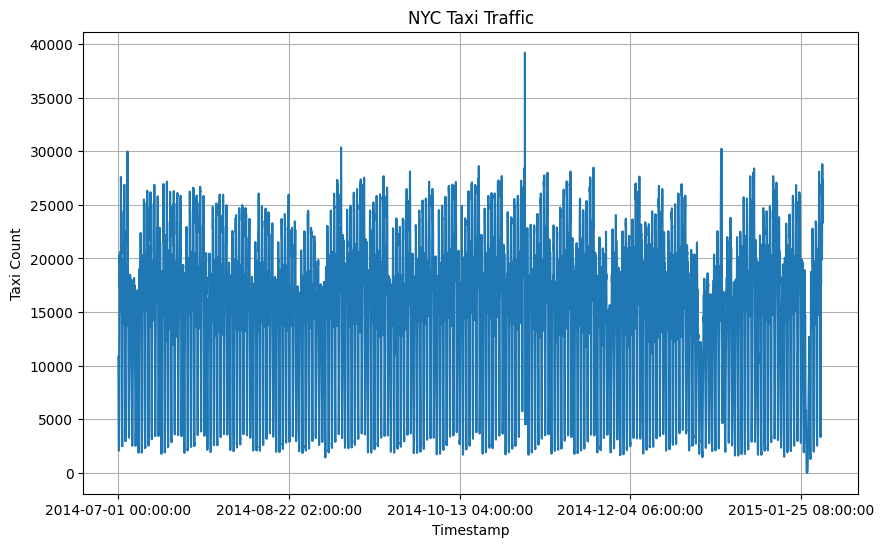

In [4]:
# Plotting our unscaled data for the number of taxis.

plot_series(
    x=timestamps,
    y=values,
    format="-",
    title="NYC Taxi Traffic",
    xlabel="Timestamp",
    ylabel="Taxi Count"
)

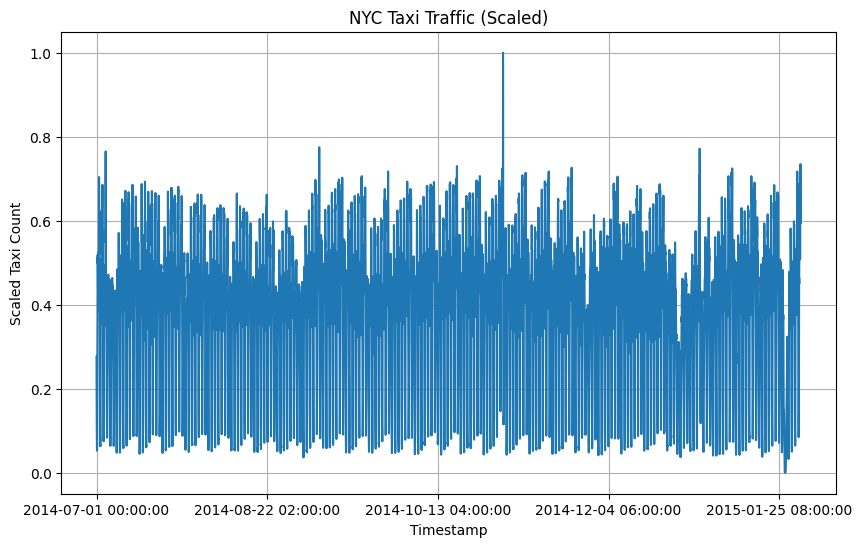

In [5]:
# Plotting the scaled version for the number of taxis, scaling ensures values stay between 0 and 1.

plot_series(
    x=timestamps,
    y=values_scaled,
    format="-",
    title="NYC Taxi Traffic (Scaled)",
    xlabel="Timestamp",
    ylabel="Scaled Taxi Count"
)

In [6]:
# Splitting the data into training and validation sets.
# Training set makes up 80% of the data while validation set accounts for 20%.

total_intervals = len(values_scaled)
split_time = int(total_intervals * 0.8)

train_time = timestamps[:split_time]
x_train = values_scaled[:split_time]

valid_time = timestamps[split_time:]
x_val = values_scaled[split_time:]

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")

Training set size: 8256
Validation set size: 2064


In [7]:
# Function to get the dataset ready for training based on specific classifications.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
# Specifying our parameters and getting it ready for training.

window_size = 336
batch_size = 64
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
# Building the model which contains a 1D convolutional layer and stacked LSTM layers.
# The output then is passed on to the DNN.

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

 # Printing the model summary.

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 336, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 336, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Get initial weights.

init_weights = model.get_weights()

In [11]:
# Running our model with the Huber loss function and Adam optimizer for 100 epochs.

optimizer = tf.keras.optimizers.Adam()

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(
    train_set,
    epochs=100,
)

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0230 - mae: 0.1627
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0015 - mae: 0.0424
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.5509e-04 - mae: 0.0333
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.1559e-04 - mae: 0.0263
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 5.9116e-04 - mae: 0.0262
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.6763e-04 - mae: 0.0229
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.8790e-04 - mae: 0.0207
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.9478e-04 - mae: 0.0211
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.9036e-04 - mae: 0.0213
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.5965e-04 - mae: 0.0202
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.2795e-04 - mae: 0.0189
Epoch 12/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.0946e-04 - mae: 0.0187
Epoch 13/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step -

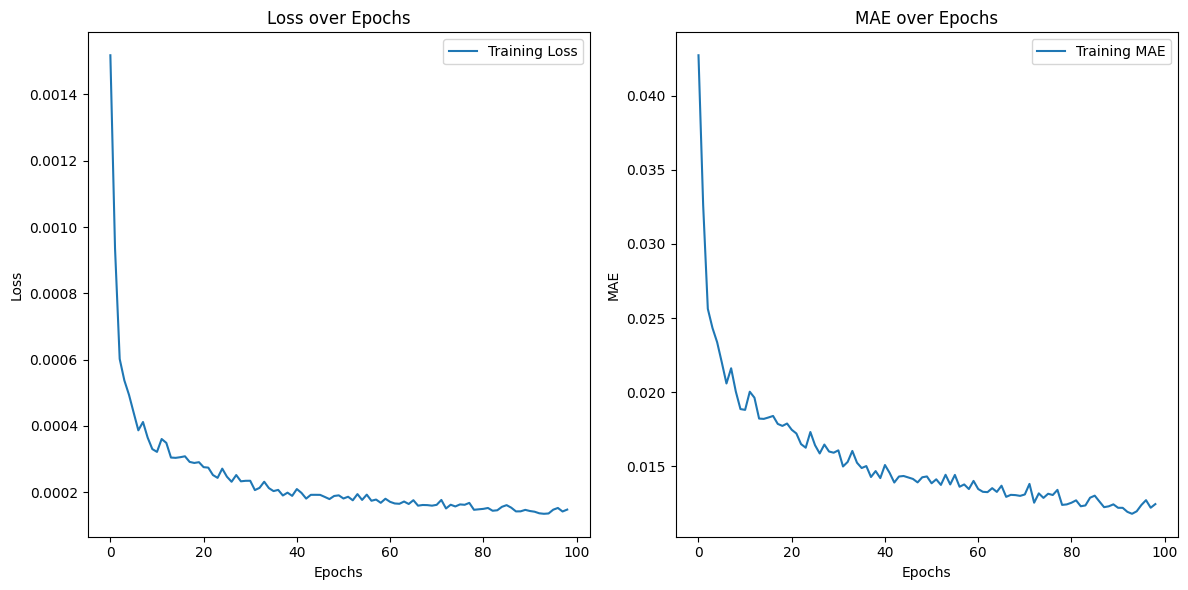

In [12]:
# Plotting our loss and mae without the initial epoch due to it skewing the graph.

loss = history.history['loss'][1:]
mae = history.history['mae'][1:]
val_loss = history.history.get('val_loss')[1:] if 'val_loss' in history.history else None
val_mae = history.history.get('val_mae')[1:] if 'val_mae' in history.history else None
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
if val_mae:
    plt.plot(val_mae, label='Validation MAE', linestyle='--')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Calculating the predictions for the values in the validation dataset.

def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)

    return forecast

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


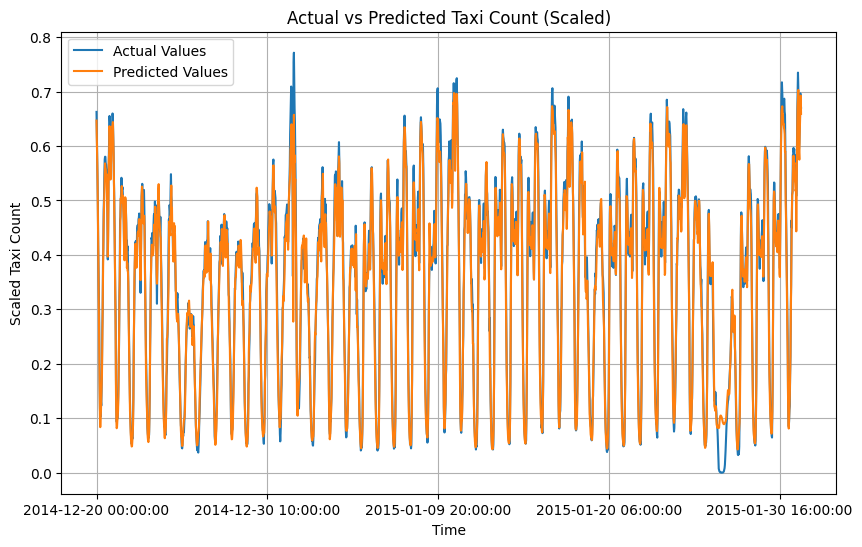

In [14]:
# Plotting the actual scaled values vs the predicted scaled values.
# Orange line representing the predictions, blue line representing the actual.

forecast_series = values_scaled[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()

plot_series(
    x=valid_time,
    y=(x_val, results),
    format="-",
    title="Actual vs Predicted Taxi Count (Scaled)",
    xlabel="Time",
    ylabel="Scaled Taxi Count",
    legend=["Actual Values", "Predicted Values"]
)

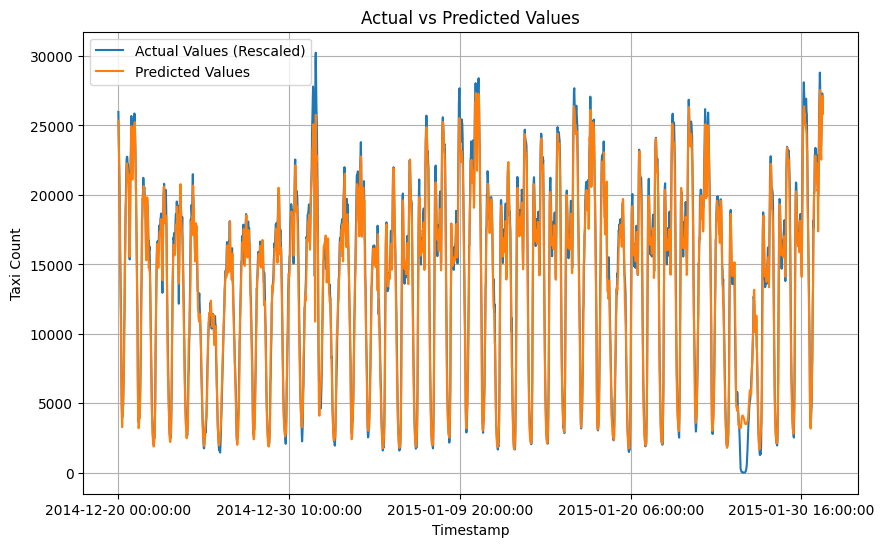

In [15]:
# Rescaling our data back to the real values and plotting the real values vs the predicted.
# Orange line representing the predictions, blue line representing the actual.

x_val_rescaled = scaler.inverse_transform(x_val.reshape(-1, 1)).flatten()
results_rescaled = scaler.inverse_transform(results.reshape(-1, 1)).flatten()

plot_series(
    x=valid_time,
    y=(x_val_rescaled, results_rescaled),
    title="Actual vs Predicted Values",
    xlabel="Timestamp",
    ylabel="Taxi Count",
    legend=["Actual Values (Rescaled)", "Predicted Values"]
)

In [16]:
# Getting the mean absolute error and percentage error to evaluate the performance of the model.

mae_test = mean_absolute_error(x_val, forecast)
print(f"Validation Set MAE: {mae_test}")
percentage_error = mae_test * 100
print(f"On average, the model's predictions are off by {percentage_error:.2f}%")

Validation Set MAE: 0.018871274315833495
On average, the model's predictions are off by 1.89%
